In [21]:
## Подключаем необходимые библиотеки
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr
from yahoo_fin.stock_info import get_data
import yahoo_fin.stock_info as si
from pandas_datareader import data as web
import datetime
from nsepy import get_history
from get_all_tickers import get_tickers as gt
from get_all_tickers.get_tickers import Region
from nsepython import *
import logging
urllib3_logger = logging.getLogger('urllib3') # Обработчик сообщений, чтобы они не выводились при сборе данных о тикерах
urllib3_logger.setLevel(logging.CRITICAL)

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [26]:
list_of_tickers = ["OGZPY", "SBER.ME", "LUKOY", "NILSY", "YNDX", "NOVKY", "OJSCY", "AUCOY", "TCSG.ME", "OPYGY", "MGNT.ME", "NLMK.ME", "OAOFY", "CHMF.ME", "SNGSP.ME", "MTSS.ME", "ALRS.ME", "SNGSP.ME", "FIVE.ME", "IMOEX.ME", "SBERP.ME", "MAIL.ME", "IRAO.ME", "VTBR.ME", "PHOR.ME", "RUAL.ME", "PIKK.ME", "MAGN.ME", "AFKS.ME", "RTKM.ME", "TRNFP.ME", "DSKY.ME", "AFLT.ME", "HYDR.ME", "POGR.ME", "TATNP.ME", "FEES.ME", "GLTR.ME", "CBOM.ME", "LSRG.ME", "RSTI.ME"]
# Задаем диапазон дат в котором нужно собирать все данные по тикерам
start = datetime.datetime(2010,1,1)
end = datetime.datetime(2020,12,31) # сегодняшняя дата, чтобы не менять вручную.
# Получаем данные из Yahoo. Именно этот способ позволяет получить данные с тикерами в столбцах.
f = pdr.DataReader(list_of_tickers, 'yahoo', start, end)

f = pd.DataFrame(f["Close"])


prices = f
# Set the index to datetime
prices.index = pd.to_datetime(prices.index)
# Convert daily frequency to monthly frequency
prices = prices.asfreq('BM')
prices.tail()

/Users/liliaromanova/opt/anaconda3/lib/python3.8/site-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'AUCOY', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/liliaromanova/opt/anaconda3/lib/python3.8/site-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'MAIL.ME', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/liliaromanova/opt/anaconda3/lib/python3.8/site-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'POGR.ME', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)
/Users/liliaromanova/opt/anaconda3/lib/python3.8/site-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'GLTR.ME', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


Symbols,OGZPY,SBER.ME,LUKOY,NILSY,YNDX,NOVKY,OJSCY,TCSG.ME,OPYGY,MGNT.ME,...,HYDR.ME,TATNP.ME,FEES.ME,CBOM.ME,LSRG.ME,RSTI.ME,AUCOY,MAIL.ME,POGR.ME,GLTR.ME
Date,,,,,,,,,,,,,,,,,,,,,
2020-08-31,4.87,225.800003,67.230003,26.100000,68.230003,147.910995,4.00,1907.199951,115.010002,4450.0,...,0.7277,533.000000,0.19572,5.879,783.000000,1.4525,NaN,NaN,NaN,NaN
2020-09-30,4.36,228.660004,57.410000,24.150000,65.250000,136.500000,4.50,2054.000000,109.099998,4971.5,...,0.7635,445.899994,0.19794,5.845,859.200012,1.4827,NaN,NaN,NaN,NaN
2020-10-30,3.85,201.089996,51.090000,23.750000,57.570000,122.000000,4.50,1886.199951,99.800003,4710.0,...,0.7221,397.200012,0.18884,5.447,906.400024,1.4432,NaN,NaN,NaN,NaN
2020-11-30,4.72,250.000000,66.000000,28.030001,68.959999,156.000000,5.78,2354.399902,94.650002,4966.5,...,0.7820,469.399994,0.20158,5.979,909.200012,1.6898,NaN,NaN,NaN,NaN
2020-12-31,5.60,NaN,68.360001,31.480000,69.580002,167.800003,5.98,NaN,106.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [42]:
# Calculate strategy returns
def get_ts_mom_strategy_returns(data, lookback=12, hold=1):

    df = pd.DataFrame()

    # Define stratregy logic
    df['lookback_returns'] = data.pct_change(lookback)
    df['future_hold_period_returns'] = data.pct_change(hold).shift(-hold)
    df = df.dropna()
    df['positions'] = np.where(df['lookback_returns'] > 0, 1, -1)

    # Calculate Strategy Returns
    df['strategy_returns'] = df['future_hold_period_returns'] * df['positions']
    
    return df['strategy_returns']


In [28]:
def analytics_returns(data_strategy_returns, title_name):

    # Calculate Sharpe ratio
    data_strategy_returns['equal_weight_portfolio'] = data_strategy_returns.mean(axis=1)
    
    sharpe = (np.mean(data_strategy_returns) /
              np.std(data_strategy_returns)*(12**0.5))
    
    sharpe.plot.bar(figsize=(10, 7), color='blue')
    plt.ylabel('Sharpe')
    plt.title(title_name)
    plt.show()

    # Calculate the cumulative strategy returns
    cum_rets = (data_strategy_returns/100 + 1).cumprod()
    cum_rets.plot(figsize=(10, 7))

    # Set title and labels for the plot
    plt.title(title_name, fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Returns', fontsize=12)
    plt.show()

    total_months = len(cum_rets)
    analytics = pd.DataFrame()

    # Calculate annalised returns
    analytics['Annualised Returns'] = (cum_rets.iloc[-2]**(12/total_months)-1)*100

    # Calculate annualised volatility
    analytics['Annualised Volatility'] = np.std(data_strategy_returns)*(12**0.5)

    # Calculate maximum drawdown
    def calc_drawdown(cum_rets):

        # Calculate the running maximum
        running_max = np.maximum.accumulate(cum_rets.dropna())

        # Ensure the value never drops below 1
        running_max[running_max < 1] = 1

        # Calculate the percentage drawdown
        drawdown = (cum_rets)/running_max - 1
        return drawdown

    analytics['Max Drawdown'] = cum_rets.apply(calc_drawdown, axis=0).min()*100

    print(analytics)

In [29]:
# commodities = ['OGZPY', 'Silver', 'Crude Oil','Platinum', 'Corn', 'Sugar', 'Wheat']

# currencies = ['EUR-USD', 'USD-JPY', 'GBP-USD', 'USD-CAD', 'USD-CHF', 'GBP-EUR']

# stock_indices = ['S&P500', 'Dow Jones Industrial Average','NASDAQ', 'Russell 2000']

# treasuries = ['TLT', 'TLH', 'IEF', 'IEI', 'SHY']

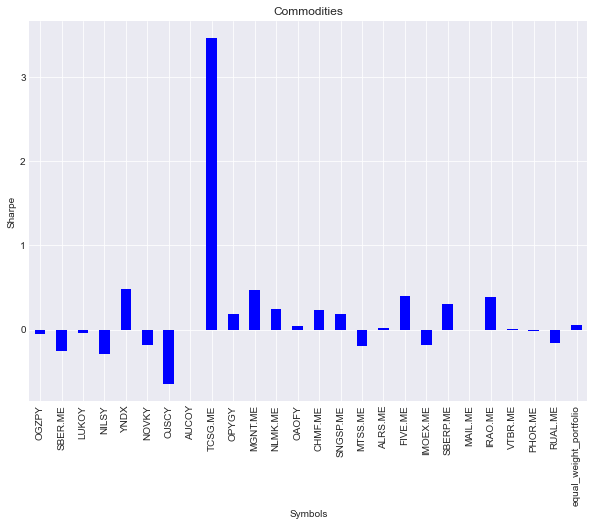

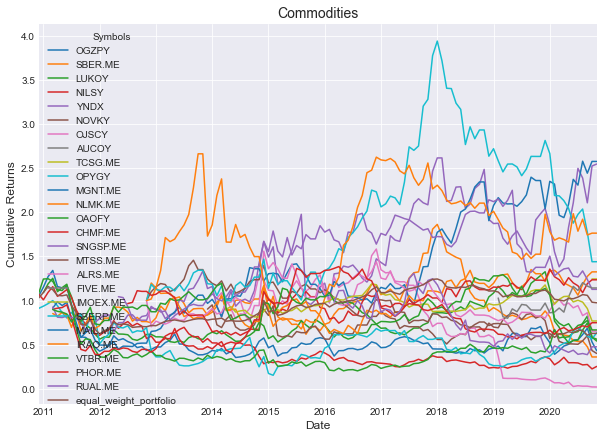

                        Annualised Returns  Annualised Volatility  \
Symbols                                                             
OGZPY                            -6.116598              35.818285   
SBER.ME                          -9.666760              30.377437   
LUKOY                            -5.239239              28.994843   
NILSY                           -13.788498              30.283037   
YNDX                              9.699334              42.509031   
NOVKY                            -7.994952              34.571622   
OJSCY                           -31.539829              53.721219   
AUCOY                                  NaN                    NaN   
TCSG.ME                           2.241980              42.993645   
OPYGY                            -5.504450              52.199862   
MGNT.ME                           9.922807              30.389449   
NLMK.ME                           2.856503              33.593149   
OAOFY                            -

In [30]:
# Import matplotlib and set the style

data_strategy_returns = prices[commodities].apply(
    get_ts_mom_strategy_returns, lookback=12, axis=0)*100

analytics_returns(data_strategy_returns, 'Commodities')

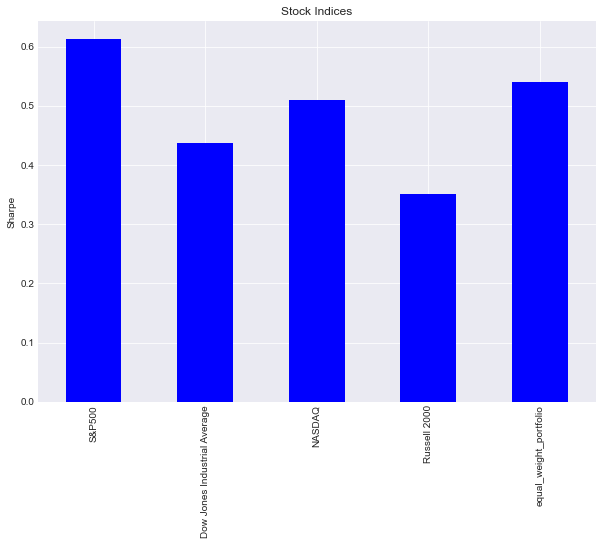

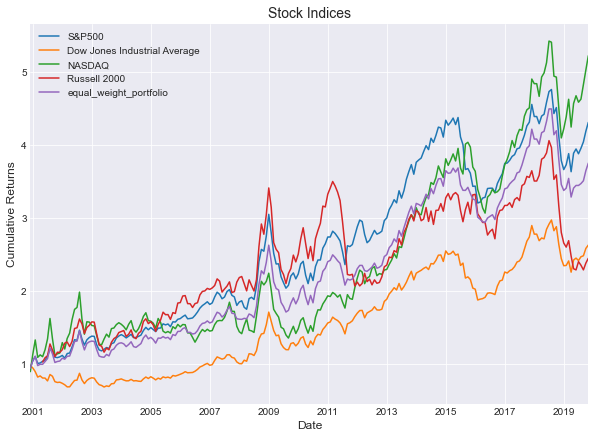

                              Annualised Returns  Annualised Volatility  \
S&P500                                  7.836061              14.257434   
Dow Jones Industrial Average            5.129655              13.874053   
NASDAQ                                  8.875897              21.770607   
Russell 2000                            4.682363              18.893079   
equal_weight_portfolio                  7.055446              15.015613   

                              Max Drawdown  
S&P500                          -33.133562  
Dow Jones Industrial Average    -31.224560  
NASDAQ                          -39.561901  
Russell 2000                    -43.585447  
equal_weight_portfolio          -34.818873  


In [18]:
data_strategy_returns = prices[stock_indices].apply(
    get_ts_mom_strategy_returns, lookback=12, axis=0)*100

analytics_returns(data_strategy_returns, 'Stock Indices')

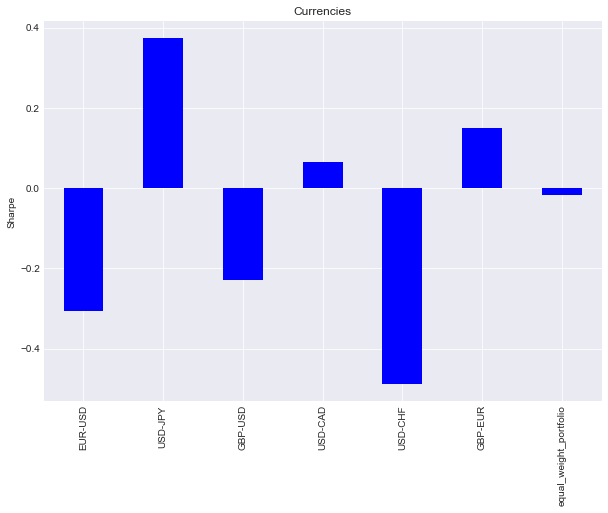

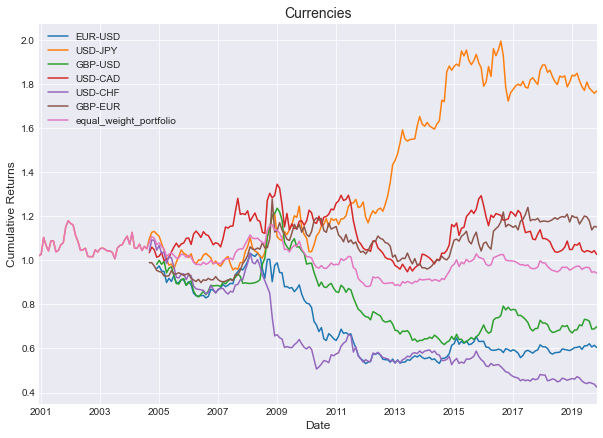

                        Annualised Returns  Annualised Volatility  \
EUR-USD                          -2.531661               9.515401   
USD-JPY                           3.012658               9.153255   
GBP-USD                          -1.946037               8.754004   
USD-CAD                           0.226125               9.253297   
USD-CHF                          -4.251877              10.343020   
GBP-EUR                           0.753705               8.633966   
equal_weight_portfolio           -0.279035               6.395750   

                        Max Drawdown  
EUR-USD                   -48.526710  
USD-JPY                   -18.915811  
GBP-USD                   -50.057051  
USD-CAD                   -29.563885  
USD-CHF                   -61.084658  
GBP-EUR                   -24.820574  
equal_weight_portfolio    -25.300060  


In [19]:
data_strategy_returns = prices[currencies].apply(
    get_ts_mom_strategy_returns, lookback=12, axis=0)*100

analytics_returns(data_strategy_returns,'Currencies')

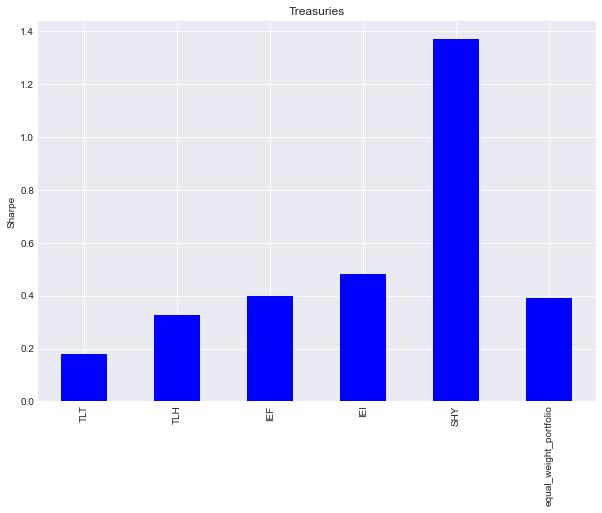

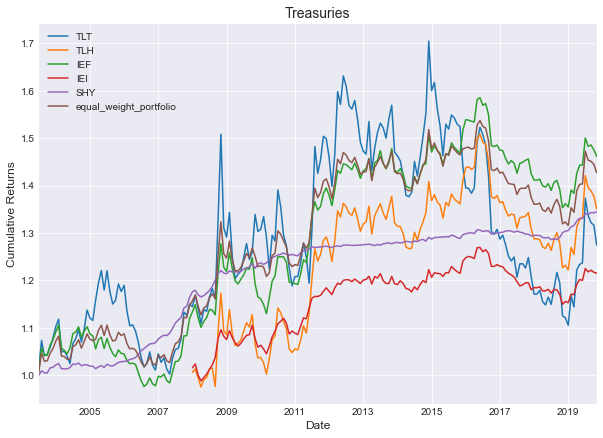

                        Annualised Returns  Annualised Volatility  \
TLT                               1.688561              12.952153   
TLH                               1.971966               8.987928   
IEF                               2.397365               6.271707   
IEI                               1.203139               3.510917   
SHY                               1.810238               1.323385   
equal_weight_portfolio            2.266232               5.995974   

                        Max Drawdown  
TLT                       -35.161082  
TLH                       -18.978424  
IEF                       -14.655894  
IEI                        -9.457173  
SHY                        -1.586925  
equal_weight_portfolio    -14.416283  


In [20]:
data_strategy_returns = prices[treasuries].apply(
    get_ts_mom_strategy_returns, lookback=12, axis=0)*100

analytics_returns(data_strategy_returns,'Treasuries')